<a href="https://colab.research.google.com/github/anu-Prakash-19/Agricultural-Crop-Recommendation-Using-KNN-Algorithm/blob/main/AI_Driven_Customer_Analytics_for_Revenue_Prediction_and_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from xgboost import XGBClassifier, XGBRegressor
import shap

In [4]:
df = pd.read_excel("online_retail_II.xlsx")
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [5]:
df.shape

(525461, 8)

In [19]:
# Remove missing values
df.dropna(inplace=True)

# Remove cancelled invoices (Invoice starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]
#keep real sales only

# Convert date(string format to dattime format)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Revenue per transaction(money earned per transcation)
df['Revenue'] = df['Quantity'] * df['Price']

# Monthly feature(activemonths)
df['Month'] = df['InvoiceDate'].dt.month

In [20]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,12
...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90,12
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,12
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,12
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50,12


In [7]:
customer_df = df.groupby('Customer ID').agg({
'Revenue': 'sum',
'Invoice': 'nunique',
'Quantity': 'sum',

'Price': 'mean',
'Month': 'nunique'
}).reset_index()


customer_df.columns = ['CustomerID', 'TotalRevenue', 'TotalInvoices', 'TotalQuantity', 'AvgPrice', 'ActiveMonths']


print(customer_df.head())

   CustomerID  TotalRevenue  TotalInvoices  TotalQuantity  AvgPrice  \
0     12346.0        372.86             11             70  6.253333   
1     12347.0       1323.32              2            828  2.295070   
2     12348.0        222.16              1            373  0.719500   
3     12349.0       2671.14              3            993  8.581765   
4     12351.0        300.93              1            261  2.355238   

   ActiveMonths  
0             4  
1             2  
2             1  
3             3  
4             1  


In [8]:
# Define churn: customers active in <=2 months
customer_df['Churn'] = np.where(customer_df['ActiveMonths'] <= 2, 1, 0)

In [9]:
features = ['TotalRevenue', 'TotalInvoices', 'TotalQuantity', 'AvgPrice']
X = customer_df[features]

y_reg = customer_df['TotalRevenue']
y_clf = customer_df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,12
...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90,12
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,12
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,12
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50,12


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Linear Regression R2: 1.0
RMSE: 3.728438241789776e-12


In [12]:
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
print("RF R2:", r2_score(y_test, y_pred_rf))

RF R2: 0.9673143817850256


In [13]:
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_test)
print("XGB R2:", r2_score(y_test, y_pred_xgb))

XGB R2: 0.18027242527968845


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       384
           1       0.87      0.96      0.91       479

    accuracy                           0.90       863
   macro avg       0.91      0.89      0.89       863
weighted avg       0.90      0.90      0.90       863



In [15]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       384
           1       0.97      0.92      0.94       479

    accuracy                           0.94       863
   macro avg       0.94      0.94      0.94       863
weighted avg       0.94      0.94      0.94       863



In [16]:
xgb_clf = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       384
           1       0.97      0.92      0.94       479

    accuracy                           0.94       863
   macro avg       0.94      0.94      0.94       863
weighted avg       0.94      0.94      0.94       863



In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

print(customer_df['Cluster'].value_counts())

Cluster
0    4303
1       9
2       2
Name: count, dtype: int64


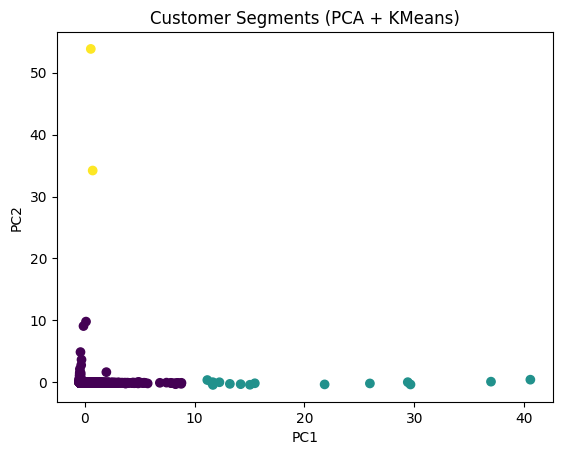

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_pca.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segments (PCA + KMeans)')
plt.show()